# Создание рекомендательной системы Megogo: использование неявных сигналов. Часть 1

Материал создан в соавторстве с Александром Макеевым, Machine Learning Engineer в R&D MEGOGO

Мы начинаем серию статей о том, как наша команда R&D с чистого листа создает рекомендательную систему видеосервиса. В первой части опишем продвинутый рекомендательный алгоритм, который базируется на данных о просмотрах видео.

В этой и последующих статьях при оценке количества обрабатываемых данных используется слово «много», за которым скрывается число от десятков до сотен миллионов «объектов» и «сигналов». Более подробная информация в данном случае является коммерческой тайной. Однако мы сможем раскрыть проценты прироста метрик качества потребления контента, значительно изменившиеся за последние полгода, в том числе благодаря вкладу обновленных, всё более комплексных рекомендательных систем.

Акцент в статьях будет смещен с математической составляющей в сторону процесса создания полноценного продукта, использующего machine learning алгоритмы. Мы пройдемся по всему рабочему процессу, начиная от сбора требований, сквозь все шаги нашего data pipeline, до развертывания на серверах.

Мы — быстрорастущая компания. Тем не менее, даже в такой ситуации считаем, что прототип должен создаваться с пониманием того, как модель будет внедряться на боевом окружении, если гипотеза пройдет валидацию и прототип будет одобрен бизнесом. Поэтому в статьях будет много информации о том, как растут наши системы, где мы делаем ошибки и как их исправляем.

Будем очень благодарны, если в комментариях вы поделитесь своим опытом создания machine learning проектов и их эксплуатации в боевом режиме.

## Постановка задачи

В самом начале разработки классической рекомендательной системы на основе лайков и дизлайков пользователей было очевидно, что охват зрителей будет не более 5% от общего количества. Чтобы предлагать рекомендации для всех наших зрителей, нам был необходим другой источник данных о пользовательской активности. Таким источником стала внутренняя система трекинга фактических просмотров контента — WatchStat.

Итак, задачу можно сформулировать таким образом: предоставить персональные рекомендации для всех пользователей, посмотревших как минимум 2 видео.

Выбранные нами метрики качественных изменений, которые улучшатся после внедрения новой системы рекомендаций:

CRR — коэффициент удержания клиентов;<br />
LTV — пожизненная ценность клиента;<br />
среднее количество часов просмотра на пользователя;<br />
процент пользовательских сессий без просмотров контента;<br />
процент рекомендованных и просмотренных единиц контента из всего каталога.<br />

## Использование неявных сигналов

Говоря о рекомендациях на основе лайков, дизлайков или рейтинга, мы подразумеваем работу с явными оценками контента зрителями. Тогда как мы планировали использовать информацию, собранную во время просмотра контента.

Такой подход оставил множество вопросов без ответов. Если пользователь смотрел видео в течение 20 секунд, что это должно нам сказать? Видео понравилось или нет? Может он решил отложить просмотр на вечер? Или вспомнил, что уже однажды смотрел этот фильм и не хочет смотреть его во второй раз? А если пользователь просмотрел 45 минут видео и ушел? Когда нет данных о факте просмотра — это позитивный или негативный сигнал?

Поэтому необходимо рассматривать подобные данные как неявные сигналы о том, что пользователю могло понравиться, а что не очень.

Базовое наивное допущение, которое лежит в основе рассматриваемого в этой статье алгоритма, состоит в том, что чем больше пользователь тратит времени на просмотр контента, тем уверенней мы можем утверждать, что контент ему нравится. Или как минимум может понравиться контент, похожий по жанру, актерскому составу или другим мета-признакам.

В итоге в качестве исходных данных было выбрано отношение времени просмотра фильма к его общей продолжительности. В нашей команде этот показатель называется «процент досмотра». Этот термин и будет использоваться ниже.

Кстати, подобные данные мы предоставляем участникам нашего онлайн-хакатона.

## Немного математики: факторизация матриц

В качестве источника данных наша рекомендательная система будет использовать неявные сигналы о предпочтениях зрителей, естественным выбором стал алгоритм факторизации матриц, получивший распространение после конкурса Netflix Prize. Если не вникать в математические дебри, то суть алгоритма крайне проста.

Входные данные представляют собой сильно разреженную матрицу вида:

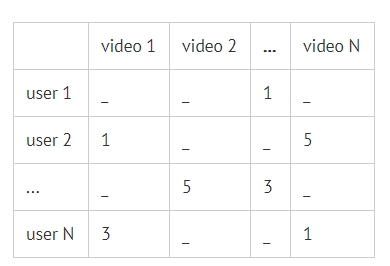

В каждой непустой ячейке содержится оценка зрителем определенной единицы контента. Размерность матрицы в нашем случае: «очень много» зрителей в строках матрицы на десятки тысяч единиц контента в столбцах матрицы.

Далее производится разложение исходной матрицы на две матрицы U и V с некоторым выбранным количеством факторов. Эти матрицы представляют собой сжатую проекцию большей части всего распределения данных с некоторыми потерями, конечно. В нашем случае факторы в сжатой форме отражают всё многообразие «вкусов зрителей». Матрица U — проекция зрителей на вкусы. Матрица V — проекция контент-объектов на вкусы. Матрицы факторов должны содержать в себе такой набор значений, чтобы умножение U x V давало в результате матрицу с близкими к исходным значениями.

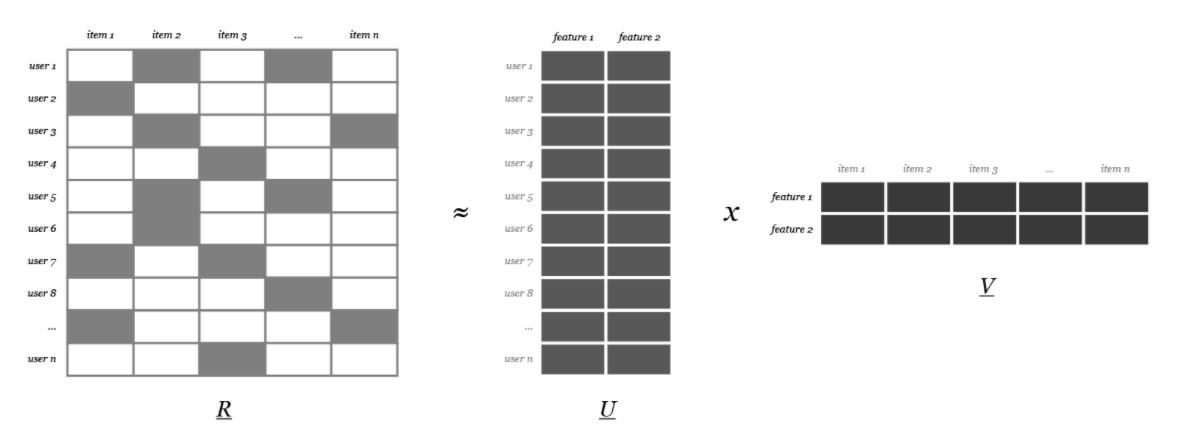

Магия этого метода состоит в том, что после умножения матриц факторов мы получаем исходную матрицу с восстановленными значениями, а изначально пустые ячейки заполнены предположениями о том, как каждый конкретный пользователь мог бы взаимодействовать с каждыми контент-объектом. Вот и всё.

Если же посмотреть на алгоритм под другим ракурсом, то суть факторизации матриц состоит в том, чтобы создать набор факторов, последовательно объясняющих некоторую часть всего распределения взаимодействий зрителей с контентом. Чем больше факторов — тем менее значимые взаимосвязи могут быть найдены и объяснены. По своей сути, каждый фактор — центр притяжения для некоторого кластера пользователей, которые имеют схожие интересы и просматриваемый контент. Поиск оптимального количества факторов, необходимых для покрытия максимального количества взаимосвязей, мы обсудим ниже.

Главная сложность этого метода — как вообще найти факторы? И тут на помощь приходит машинное обучение в виде метода оптимизации Gradient Descent. Для его работы необходима дифференцируемая метрика (функция потерь), которую мы будем минимизировать. Очевидно, что метрика должна показывать ошибку приближения произведения матриц факторов к исходной матрице. Базовая формула выглядит так:

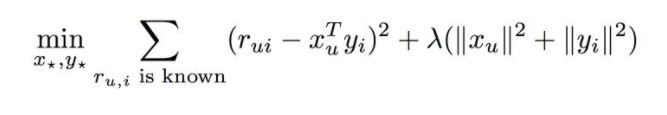


Формула позволяет не только вычислить ошибку, но также включает в себя L2 регуляризацию, сила воздействия которой задается параметром λ. Описание метода работы градиентного спуска мы оставим за пределами этой статьи. Отметим лишь то, что регуляризация будет упоминаться ниже как один из параметров тонкой настройки модели.

Существует ряд алгоритмов поиска факторов. Один из них — SGD (Stochastic Gradient Descent), работающий на семплах данных, обеспечивая хорошую масштабируемость, но не гарантирующий сходимость. Основной алгоритм в нашей статье — ALS (Alternating Least Squares), который также выполняет градиентный спуск. Его особенность состоит в том, что каждая итерация спуска происходит в два этапа (частное дифференцирование с поочередной фиксацией матриц факторов пользователей и фильмов) и гарантирует плавную сходимость.

Нюанс нашего случая состоит в том, что вместо явных оценок зрителей необходимо использовать неявный показатель в виде процента досмотра. Для этого есть модифицированная методика поиска факторов, прекрасно описанная в оригинальной публикации. Ее основная идея состоит в том, что исходные данные рассматриваются не как абсолютные оценки контента пользователем, а как уровни доверия факту просмотра контента, допуская предположение, что если контент досмотрен до конца, то он, скорее всего, понравился. Соответственно, модифицируется формула расчета ошибки:

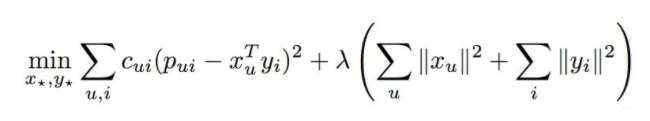


Теперь исходная матрица Pui — это бинарная матрица фактов просмотра контента, а дополнительная матрица Cui — это уровень доверия факту просмотра. Плюс L2 регуляризация.

Ключевой момент здесь — расчет матрицы уровней доверия Cui. В простейшем случае он выполняется по формуле Cui = 1 + αRui, где Rui — исходная матрица с процентами досмотра, α — эмпирически подбираемый коэффициент. Авторы публикации рекомендуют проводить эксперименты с преобразованием имеющихся данных в уровень доверия. В ходе дальнейшей оптимизации гиперпараметров в формулу расчета была добавлена нелинейность и ещё один оптимизационный параметр. Подробнее об этом мы расскажем в соответствующем разделе статьи.

Учитывая, что сложно реализовывать подобные алгоритмы, способные переработать наш «очень большой» объем данных, мы используем готовую реализацию Apache Spark ALS (как и всю платформу в целом).

С алгоритмами разобрались, можно углубиться в разбор непосредственно реализации.

## Hard&Soft

В нашей команде основной язык программирования — Python. Некоторые шаги data pipeline реализованы на Scala в угоду скорости работы на платформе Apache Spark. Для исследований используется Jupyter Notebook. Расчеты производятся, очевидно, тоже на Apache Spark. Базы данных: MongoDB и MySQL.

Все исходные данные собираются и хранятся на in-house серверах в датацентрах Megogo. На них же работает API, раздающий пользователям предварительно рассчитанные рекомендации. Работает API на стандартном стеке: Python, Flask, MongoDB, Memcached, NGINX.

Исследования, разработка и тренировка моделей, запуск production data pipeline производятся на AWS EC2 серверах. Данные, необходимые для расчета моделей, хранятся на AWS S3. Обмен данными между корпоративными подсетями и серверами на AWS производится по защищенным туннелям.

## Сырые данные

Нам сильно повезло в том, что система трекинга WatchStat начала свою работу задолго до того, как мы начали использовать собранные ею данные. Как следствие, в нашем распоряжении было «очень много» (мы и сами не знаем полный объем) исторических данных, собранных за несколько лет. Для любого Data Scientist это фантастический старт. Потому что мы сразу перепрыгнули мучительные этапы создания трекинговых систем, бесконечных исправлений багов и долгосрочного сбора первоначального объема данных с приемлемым качеством.

С другой стороны, данные были собраны в «очень много» гигабайт текстовых CSV, разбитых на две раздельные сущности, которые необходимо было объединить по ключу. Данные хранились на HDFS, и у наших бизнес-аналитиков была возможность работать с ними через Hadoop+Hive, но скорость обработки каждого запроса была крайне низкой. Поэтому было принято решение создать ETL (extract, transform, load) процессинг для извлечения из CSV полезных для нас данных и сохранения их в удобном для дальнейшего использования формате.

Исходные данные разбиты на ежесуточные архивы. Каждый архив состоит из:

данных о сессиях (старты проигрывания видео), включающие в себя информацию о пользователе, видео-объекте, устройстве и другую мета-информацию;<br />
данных о тиках (периодические сигналы о том, что сессия проигрывания видео всё ещё активна), посчитав которые можно узнать фактическую продолжительность каждой сессии.<br />

Дальнейшие исследования показали, что сырые данные включали в себя большое количество аномалий, связанных как с техническими нюансами сбора этих данных, так и с поведенческими факторами. Одни аномалии были очевидны, поэтому нужно было лишь найти способ работы с такими данными. Другие аномалии были найдены в процессе обучения и валидации моделей благодаря метрикам, визуальному контролю результатов и здоровой доли перфекционизма.

## ETL

Этот этап состоит из извлечения и преобразования сырых данных в пригодный для дальнейшего использования формат.

Во-первых, с помощью Apache Spark один раз в сутки производится чтение и разбор информации из CSV формата. На этом шаге сырые данные из CSV:

проходят предварительную очистку;<br />
сессии с информацией о начале просмотра видео и событиях продолжения просмотра соединяются в единый датасет;<br />
по идентификатору сессии записи группируются;<br />
производится ряд манипуляций для получения последовательностей событий в рамках каждой сессии;<br />
самое главное: производится расчет длительности сессии и «процент досмотра», который используется для работы рекомендательного алгоритма ALS;<br />
записываются на S3 в Parquet-формате.<br />

Таким образом мы получаем посуточную статистику в интересующем нас формате.

Далее мы берем рассчитанную статистику за длительный период и конвертируем в формат входных данных для алгоритма Spark ALS. По-факту, мы рассчитываем три модели, используя различные промежутки исторических данных (суммарно за 14 месяцев) и на одном из финальных этапов делаем микс результатов. Но подробнее об этом позже.

Стоит отметить, что этап ETL практически линейно масштабируется при увеличении количества процессорных ядер, доступных Apache Spark. Первоначально преобразования выполнялись скриптом на Python. Это влекло за собой необходимость сериализации и передачи данных между Spark и Python-процессами, которые занимались фактической обработкой данных. Несмотря на то, что скорость работы была приемлемой, было очевидно, что процесс можно значительно ускорить. Поэтому задача для Spark была переписана на Scala, что сразу дало прирост скорости выполнения в 2-3 раза на тех же вычислительных ресурсах.

## Предварительный анализ данных

Анализ данных, конечно, не входит в production data pipeline и служит исключительно исследовательским целям. Но без этого шага вся дальнейшая деятельность не имеет большого смысла. Поэтому мы немного расскажем, как процесс анализа организован у нас.

Перед тем как создавать модель, необходимо понять данные, с которыми мы будем работать. Все исследования производятся в Jupyter Notebook, интегрированными с Apache Spark. Основная цель — выяснить качество данных и на раннем этапе выявить мусор, пропуски и аномальные выбросы. К примеру, попадаются сессии просмотра продолжительностью целые сутки. Есть зрители, высматривающие сотни видео за месяц, и данные о них превращаются в белый шум. Часто в случае сбоя проигрывателя стартует новая сессия просмотра и с точки зрения нашей системы получается два просмотра с низким процентом досмотра.

Все нюансы данных, о которых мы узнали на этом этапе, сразу учитываются и мы выполняем дополнительные манипуляции с данными на этапе ETL. Борьба за чистоту данных и выявление аномалий — бесконечный процесс, который не должен прекращаться. Каждый день собираются новые данные, на которые могут повлиять неизвестные нам факторы. Постоянный контроль качества входящих данных — обязательное условие стабильно качественного результата работы всей системы.

Использование Jupyter Notebook сильно облегчает проведение исследований, визуализацию результатов и командную работу над задачей. Кроме того, частично решается вопрос документирования, потому что результаты работы с кодом, рассчитанными результатами и подробными комментариями можно прикрепить к задаче в трекинговой системе. Итоги работы никогда не будут потеряны и легко доступны.

## Метрики качества рекомендаций

На данный момент у нас нет полноценной возможности проведения А/Б тестирования. Как следствие, мы вынуждены опираться исключительно на оффлайн-метрики качества. У нас их четыре:

MAP@10 — самая жесткая метрика, отражающая точность попадания рекомендаций в видимую область рекомендательной ленты;<br />
MAP@50 — точность попадания в рамках всей рекомендательной ленты;<br />
процент пользователей, для которых было хотя бы одно попадание рекомендаций;<br />
процент каталога контента, предложенного в рекомендациях.<br />

Во время настройки гиперпараметров модели невозможно оптимизировать все метрики одновременно. Всегда существует риск, что при улучшении показателей по одной метрике, показатели по другой могут ухудшиться. Не существует «идеального решения», всегда необходимо идти на разумный компромисс, понимая, чем мы жертвуем, ухудшая какую-то из имеющихся метрик.

Большое количество метрик может поставить в тупик при настройке модели. Но с другой стороны это позволяет более тонко чувствовать модель и ее изменчивость в зависимости от входных данных и гиперпараметров.

Само собой, у нас есть интерфейс, где мы визуально контролируем качество рекомендаций по пользователям. Но этот метод чаще всего используется для фактического сравнения различных рекомендательных алгоритмов, когда визуальная оценка может дать больше информации, чем голые цифры, усредненные на огромной выборке пользователей.

## Тренировка модели на базе алгоритма ALS

Мы собрали данные и определились с метриками. Наконец можно рассчитать рекомендации.

Используя классический подход ML, из имеющегося объема данных мы удаляем всех пользователей, у которых меньше 2 просмотров, и разбиваем датасет на две части: тренировочную и проверочную. Конечно, можно использовать технику cross-validation, но учитывая, что один просчет ALS алгоритма даже на очень серьезном железе может занимать несколько часов, для базовых экспериментов мы решили ограничиться разбиением выборки на две.

Итак, мы используем тренировочную часть для обучения модели и проверочную для расчета метрик качества предсказания. К сожалению, в деталях кроется дьявол, который сильно уменьшает уровень доверия к оффлайн-метрикам, но из-за отсутствия альтернатив приходится с этим уровнем мириться. Дело в том, что в проверочную выборку попадают фильмы, которые пользователи действительно посмотрели, используя текущую на момент просмотра версию интерфейса и наполнения рекомендательных лент. То есть контент, который пользователь смог найти. Но высока вероятность, что зритель просто не добрался до интересного ему контента. Таким образом с помощью валидирующей выборки мы можем проверить качество только тех рекомендаций, которые легко доступны для пользователя через интерфейс приложения или веб-сайта. Получается, что новая рекомендательная система потенциально может находить действительно интересный для нашего зрителя контент, но фактически этот контент будет ухудшать оффлайн-метрики — пользователь понятия не имеет, что у нас этот контент есть.

С пониманием, что в мире нет ничего идеального, тренируем ALS модель, получаем рекомендации по каждому клиенту платформы и рассчитываем значения всех метрик для тренировочной и проверочной выборки. Основная цель всех дальнейших экспериментов с гиперпараметрами модели — найти такую комбинацию значений, при которой мы получим оптимальный по качеству результат за приемлемое время расчета. Набор метрик и динамика их изменения по тренировочной и проверочной выборкам дает нам возможность найти оптимальный вариант.

## Поиск оптимальных значений гиперпараметров

У алгоритма ALS есть несколько важных для нас параметров:

rank — количество факторов (об этом шла речь в математической части статьи);<br />
maxIter — количество итераций (напоминаем, что алгоритм у нас итеративный — градиентный спуск);<br />
alpha — эмпирический коэффициент, влияющий на расчет степени доверия (которая в нашем случае считается на основании процента досмотра);<br />
regParam — коэффициент регуляризации, позволяющий управлять переобучением модели.<br />

Кроме того, в ходе исследований мы выяснили, что оригинальный процент досмотра не дает достаточного разделения результирующей степени доверия к просмотру между «скорее всего, нравится» и «скорее всего, не нравится». Например, средний процент досмотра хорошего фильма — 0,8-0,9; не интересного контента — 0,1-0,2. Использование только коэффициента alpha показало, что пользователи продолжают получать на верхних строчках рекомендации фильмов, которые они действительно смотрели, но процент досмотра крайне низкий. Говоря проще, ALS считал позитивными результатами всё, что насмотрел пользователь, несмотря на низкий процент досмотра.

Для решения этой проблемы были проведены эксперименты с исходными данными, в ходе которых мы выяснили, что наилучший результат обеспечивает возведение процента досмотра в степень от 2 до 3. Таким образом, начальная формула преобразования получила вид: Cui = 1 + α(Rui)N, где N стал еще одним гиперпараметром модели.

Существует ряд методик подбора гиперпараметров, но на начальном этапе разработки прототипа подбор проводился вручную. На основании динамики изменения всех метрик значения гиперпараметров изменялись в ту или иную сторону. В итоге за разумное время (с учетом длительного времени расчета каждой модели) были подобраны оптимальные значения, которые мы использованы в продакшен-решении.

Приведем несколько примеров зависимости значений выбранных метрик от гиперпараметров модели.

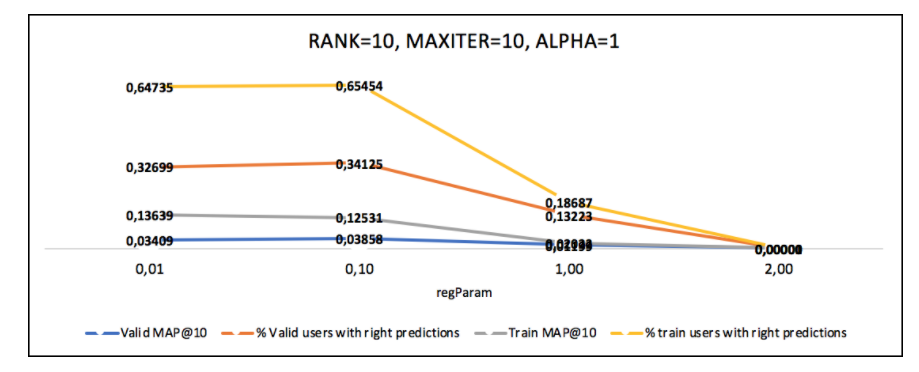

На этом графике видно, как изменяются значения метрик на тренировочной и проверочной выборках в зависимости от значения регуляризации при постоянных значениях ранга матрицы, количества итераций и alpha.

Здесь продемонстрировано аномальное поведение модели при небольшом значении alpha=1. Более привычно выглядит следующий график, который мы разберем подробно.

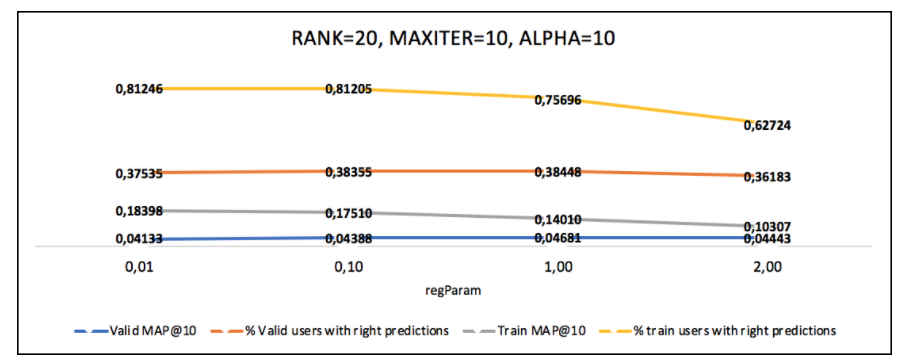

Единственное отличие этих экспериментов от предыдущих — в увеличенном значении alpha=10.

С ростом значения регуляризации происходит следующее:

падение на 20% количества пользователей с совпадениями предсказаний и реальных просмотров на тренировочной выборке, но при этом незначительные изменения на проверочной выборке;<br />
падение на 0,08 значения метрики MAP@10 на тренировочной выборке и рост на 0,05 на проверочной выборке.<br />
Эксперименты показывают, что оптимальное значение регуляризационного параметра равно 1,0.

Регуляризация позволяет нам не дать переобучиться модели на тренировочной выборке и достичь оптимальных значений метрик для проверочной выборке.

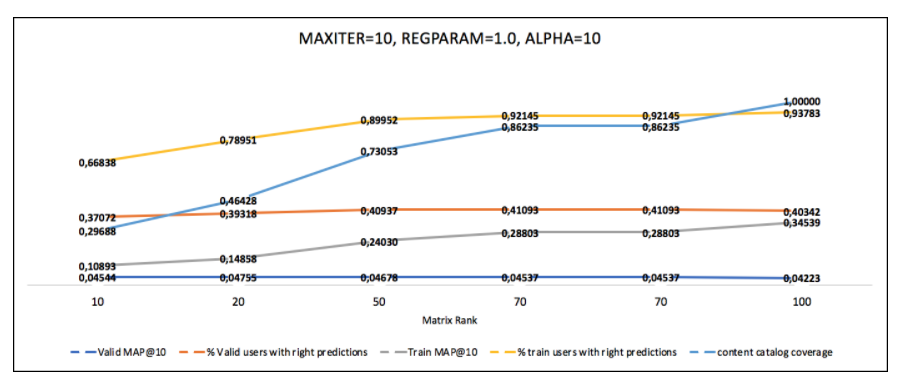

На этом графике добавлена еще одна метрика — уровень покрытия каталога контента. На этот раз в широком диапазоне от 10 до 100 изменяется количество факторов, от которого напрямую зависит количество паттернов, которые можно обнаружить при факторизации матрицы.

На графике легко заметить рост точности на тренировочной выборке с 0,1 до 0,34 и процент пользователей с совпадениями с 66% до 93%. При этом для проверочной выборки точность растет с увеличением количества факторов до 20 и потом плавно падает. Это яркий пример процесса переобучения модели, который необходимо контролировать другими гиперпараметрами.

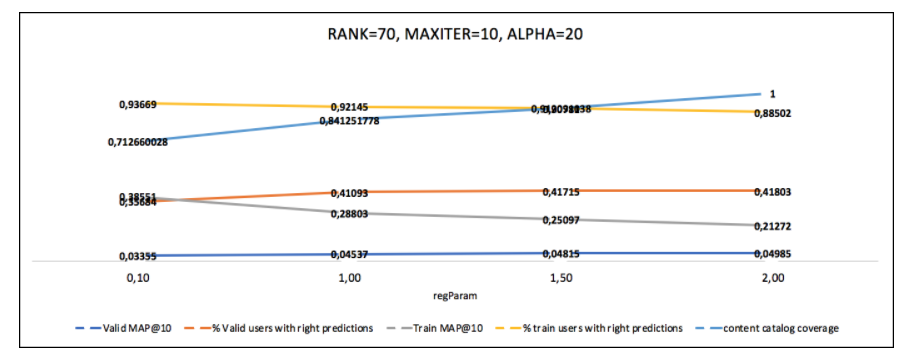

Поэтому мы фиксируем количество факторов 70, количество итераций 10, alpha=20 и пробуем подобрать необходимый уровень регуляризации.

Хорошо видно, как с ростом значения параметра регуляризации падает точность и количество счастливых пользователей на тренировочной выборке и стабильно растет точность и количество пользователей на проверочной выборке.

Отдельно хотелось бы сказать об охвате каталога. Чтобы разместить значения метрики на графике, нам пришлось конвертировать абсолютные цифры количества контент-объектов в относительные.

В абсолютных значениях цифры выглядят примерно так:

в худшем случае охват каталога не превышает 300 фильмов;<br />
в лучшем случаем — 4800 фильмов.<br />

Следовательно, по мере настройки модели мы улучшили охват более чем в 10 раз. Это крайне важная метрика, так как одна из наших основных задач — предлагать как можно более широкий спектр фильмов на любой вкус.

Что касается метрики MAP@10, то цифры такие:

худшая модель — 0,012;<br />
лучшая модель — 0,050.<br />

Итоговый рост — в 5 раз. Данная метрика зависит не только от количества совпадений наших рекомендаций с реальными просмотрами, но и от расположения фильмов в предлагаемом массиве рекомендаций. Поэтому в некоторых случаях абсолютно количество удовлетворенных пользователей может не увеличиваться, но при этом будет улучшаться MAP метрика. Это говорит нам о том, что алгоритм располагает на более высоких позициях интересующие пользователей фильмы. Видимая область ленты, как правило, ограничена 5-7 элементами, поэтому мы обязаны располагать там наиболее интересный контент, улучшая таким образом его доступность.

## Подведение промежуточных итогов

В этой статье мы рассказали об алгоритмах, метриках, входящих данных, предварительных исследованиях, тренировках модели и подборах гиперпараметров. В следующем материале этой серии раскроем дальнейшие шаги расчета полного data pipeline, оптимизацию при раздаче рекомендаций через API, логирование и мониторинг всей системы. Также мы поделимся мыслями и планами по дальнейшему развитию системы в зрелый продукт.

https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html#examples